# Pre-RA Flow PB1_igPos_non_naive_b: Cell type level subclustering

Creating frequency stat tables with cell type level and live frequencies/proportions

## Set Up

In [1]:
%config Completer.use_jedi = False
import scyan as sy
import os
import glob
import anndata
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scanpy as sc
import scanpy.external as sce
import copy
from concurrent.futures import ProcessPoolExecutor


print(sy.__version__)
print(anndata.__version__)

/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


1.5.1
0.10.6


In [2]:
#### ==== parameter set up ==== ####
# define the working path
panel = "PB1"
# define l1 cell types to subset
cell_types = 'total_b_cells_igPos_non_naive_b'
# define markers used for clustering


data_path='/home/jupyter/projects/pre-ra/flow/raw-data/' + panel + '/cache/'
fig_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/results/' + panel + '_igPos_non_naive_b_celltype_subsample'  + "/"
proj_name = 'pre-ra_flow_clustering_' + panel
output_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/data/' +panel + '/'

if not os.path.exists(fig_path): os.makedirs(fig_path)
    
if not os.path.exists(output_path): os.makedirs(output_path)

# define scanpy verbose levels
sc.settings.verbosity = 3
sc.settings.figdir = fig_path
sc.settings.n_jobs = 30

## Functions

In [3]:
def read_anndata_files(file_tuples):
    """
    Read Anndata objects from H5AD files and store them in a dictionary with custom names.

    Parameters:
        file_tuples (list of tuples): List of tuples where each tuple contains filename and desired name.

    Returns:
        dict: Dictionary containing Anndata objects with custom names.
    """
    anndata_dict = {}
    for filename, name in file_tuples:
        anndata_obj = anndata.read_h5ad(filename)
        anndata_dict[name] = anndata_obj
    return anndata_dict

In [4]:
def save_anndata_list(anndata_list, filenames):
    """
    Save a list of Anndata objects to separate H5AD files.

    Parameters:
        anndata_list (list): List of Anndata objects to be saved.
        filenames (list): List of filenames to save Anndata objects.

    Returns:
        None
    """
    # zip() combines two lists into a single tuple
    for anndata_obj, filename in zip(adata_downsampled_celltypes, filenames):
        print(adata_downsampled_celltypes[anndata_obj])
        adata_downsampled_celltypes[anndata_obj].write_h5ad(filename)

In [5]:
# make a function to find files
def get_filepaths_with_glob(root_path: str, file_regex: str):
    return glob.glob(os.path.join(root_path, file_regex))

In [6]:
#### parallelized leiden clustering
def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs
 
def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]
 
    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]
 
    return adata

## Read in data

In [7]:
filenames = get_filepaths_with_glob(output_path, "adata_leiden_res_1.0*" + cell_types + "_" +panel+".h5ad")  
filenames

['/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/adata_leiden_res_1.0_scaled_harmonized_umap_downsmpl_celltypes_total_b_cells_igPos_non_naive_b_PB1.h5ad']

In [8]:
# Extract the cell types between "celltypes_" and "PT1.h5ad"
cell_types = [path.split('celltypes_')[1].split('_' +panel+'.h5ad')[0] for path in filenames]
cell_types

['total_b_cells_igPos_non_naive_b']

In [9]:
## turn filenames and cell types into tuple
file_tups = list(zip(filenames, cell_types))
file_tups

[('/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/adata_leiden_res_1.0_scaled_harmonized_umap_downsmpl_celltypes_total_b_cells_igPos_non_naive_b_PB1.h5ad',
  'total_b_cells_igPos_non_naive_b')]

In [10]:
adata_downsampled_celltypes = read_anndata_files(file_tups)
adata_downsampled_celltypes

{'total_b_cells_igPos_non_naive_b': AnnData object with n_obs × n_vars = 1854019 × 24
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023', 'leiden_res_1.0'
     var: 'antigens', 'gating_antigens', 'highly_variable'
     uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds'
     obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances'}

In [11]:
cell_types

['total_b_cells_igPos_non_naive_b']

## Calculate proportions

Since total live freq and cell type freq is already labeled in counts_freq_celltypes_sample_select*.csv,
use these sum as denominator

In [31]:
l1_counts= pd.crosstab(adata_downsampled_celltypes[cell_types[0]].obs['sample_id'], adata_downsampled_celltypes[cell_types[0]].obs['l1_labels'], margins=True)

l1_counts.reset_index().rename_axis(None, axis=1)

l1_counts = l1_counts.add_prefix("downsample_") 
l1_counts.reset_index(inplace=True)

l1_counts

l1_labels,sample_id,downsample_total_b_cells,downsample_All
0,PB00052-02,13748,13748
1,PB00055-02,15998,15998
2,PB00056-02,13741,13741
3,PB00057-02,11891,11891
4,PB00058-03,7335,7335
...,...,...,...
128,PB04671-00,30302,30302
129,PB04906-00,26936,26936
130,PB04933-00,28360,28360
131,PB04937-00,31138,31138


In [25]:
adata_downsampled_celltypes[cell_types[0]].obs['sample_id']

30          PB00467-01
58          PB00467-01
66          PB00467-01
112         PB00467-01
133         PB00467-01
               ...    
57762113    PB02292-00
57762180    PB02292-00
57762211    PB02292-00
57762307    PB02292-00
57762309    PB02292-00
Name: sample_id, Length: 1854019, dtype: category
Categories (132, object): ['PB00052-02', 'PB00055-02', 'PB00056-02', 'PB00057-02', ..., 'PB04671-00', 'PB04906-00', 'PB04933-00', 'PB04937-00']

In [41]:
%%time

## define leiden res of interest

leiden_res = {'total_b_cells_igPos_non_naive_b': 'leiden_res_1.0'}

for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    l1_counts= pd.crosstab(sub_adata.obs['sample_id'], sub_adata.obs['l1_labels'])

    l1_counts.reset_index().rename_axis(None, axis=1)

    l1_counts = l1_counts.add_prefix("downsample_") 
    l1_counts.reset_index(inplace=True)

    print(l1_counts)
    
    freq_counts = sy.tools.cell_type_ratios(sub_adata, groupby=['sample_id','l1_labels'],normalize=False, key=leiden_res[label], among=None)
    freq_prop = sy.tools.cell_type_ratios(sub_adata, groupby=['sample_id','l1_labels'],normalize=True, key=leiden_res[label], among=None)
    
    # longwise format
    freq_count_melt = freq_counts.melt(ignore_index=False, value_name="counts", var_name='cluster' ).reset_index()

    #remove 'ratio' suffix in leiden column
    freq_count_melt["cluster"] = freq_count_melt["cluster"].str.replace(' count','', regex = True)

    freq_count_melt["cluster"] = "c" +freq_count_melt["cluster"]

    freq_count_melt = freq_count_melt.merge(l1_counts,how= 'inner')

    freq_count_melt
    
    freq_prop_melt = freq_prop.melt(ignore_index=False, value_name="frequency", var_name='cluster').reset_index()

    #remove 'ratio' suffix in leiden column
    freq_prop_melt['cluster'] = freq_prop_melt['cluster'].str.replace(' ratio','', regex = True)

    freq_prop_melt['cluster'] = "c" +freq_prop_melt['cluster']

    freq_prop_melt
    
    counts = freq_count_melt.merge(freq_prop_melt[['sample_id','cluster', 'frequency']], how = 'inner', on = ['sample_id','cluster'])

    counts['leiden_res'] = leiden_res[label]
    
    counts.to_csv(output_path + "cell_frequency_table_downsmpl_sample_select_" + label + "_" +  leiden_res[label] +"_"  +panel + ".csv",index=False)
    
    
    

Key: total_b_cells_igPos_non_naive_b
Value: AnnData object with n_obs × n_vars = 1854019 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023', 'leiden_res_1.0'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
l1_labels   sample_id  downsample_total_b_cells
0          PB00052-02                     13748
1          PB00055-02                     15998
2          PB00056-02                     13741
3          PB00057-02                     11891
4          PB00058-03                      

/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/tools/biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/tools/biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)


CPU times: user 674 ms, sys: 0 ns, total: 674 ms
Wall time: 672 ms


In [38]:
counts

,sample_id,l1_labels,cluster,counts,downsample_total_b_cells,frequency,leiden_res
0,PB00052-02,total_b_cells,c0,1920,13748,0.139657,leiden_res_1.0
1,PB00055-02,total_b_cells,c0,3237,15998,0.202338,leiden_res_1.0
2,PB00056-02,total_b_cells,c0,3483,13741,0.253475,leiden_res_1.0
3,PB00057-02,total_b_cells,c0,2523,11891,0.212177,leiden_res_1.0
4,PB00058-03,total_b_cells,c0,495,7335,0.067485,leiden_res_1.0
...,...,...,...,...,...,...,...
3031,PB04652-00,total_b_cells,c22,1,13029,0.000077,leiden_res_1.0
3032,PB04671-00,total_b_cells,c22,2,30302,0.000066,leiden_res_1.0
3033,PB04906-00,total_b_cells,c22,0,26936,0.000000,leiden_res_1.0
3034,PB04933-00,total_b_cells,c22,2,28360,0.000071,leiden_res_1.0


## Expression plots

In [12]:
fig_path = fig_path + panel + "_leiden/"
print(fig_path)
if not os.path.exists(fig_path): os.makedirs(fig_path)
sc.settings.figdir = fig_path

leiden_res = {'total_b_cells_igPos_non_naive_b': 'leiden_res_1.0'}


/home/jupyter/projects/pre-ra/flow/02-clustering/results/PB1_igPos_non_naive_b_celltype_subsample/PB1_leiden/


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden_res_1.0']`


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


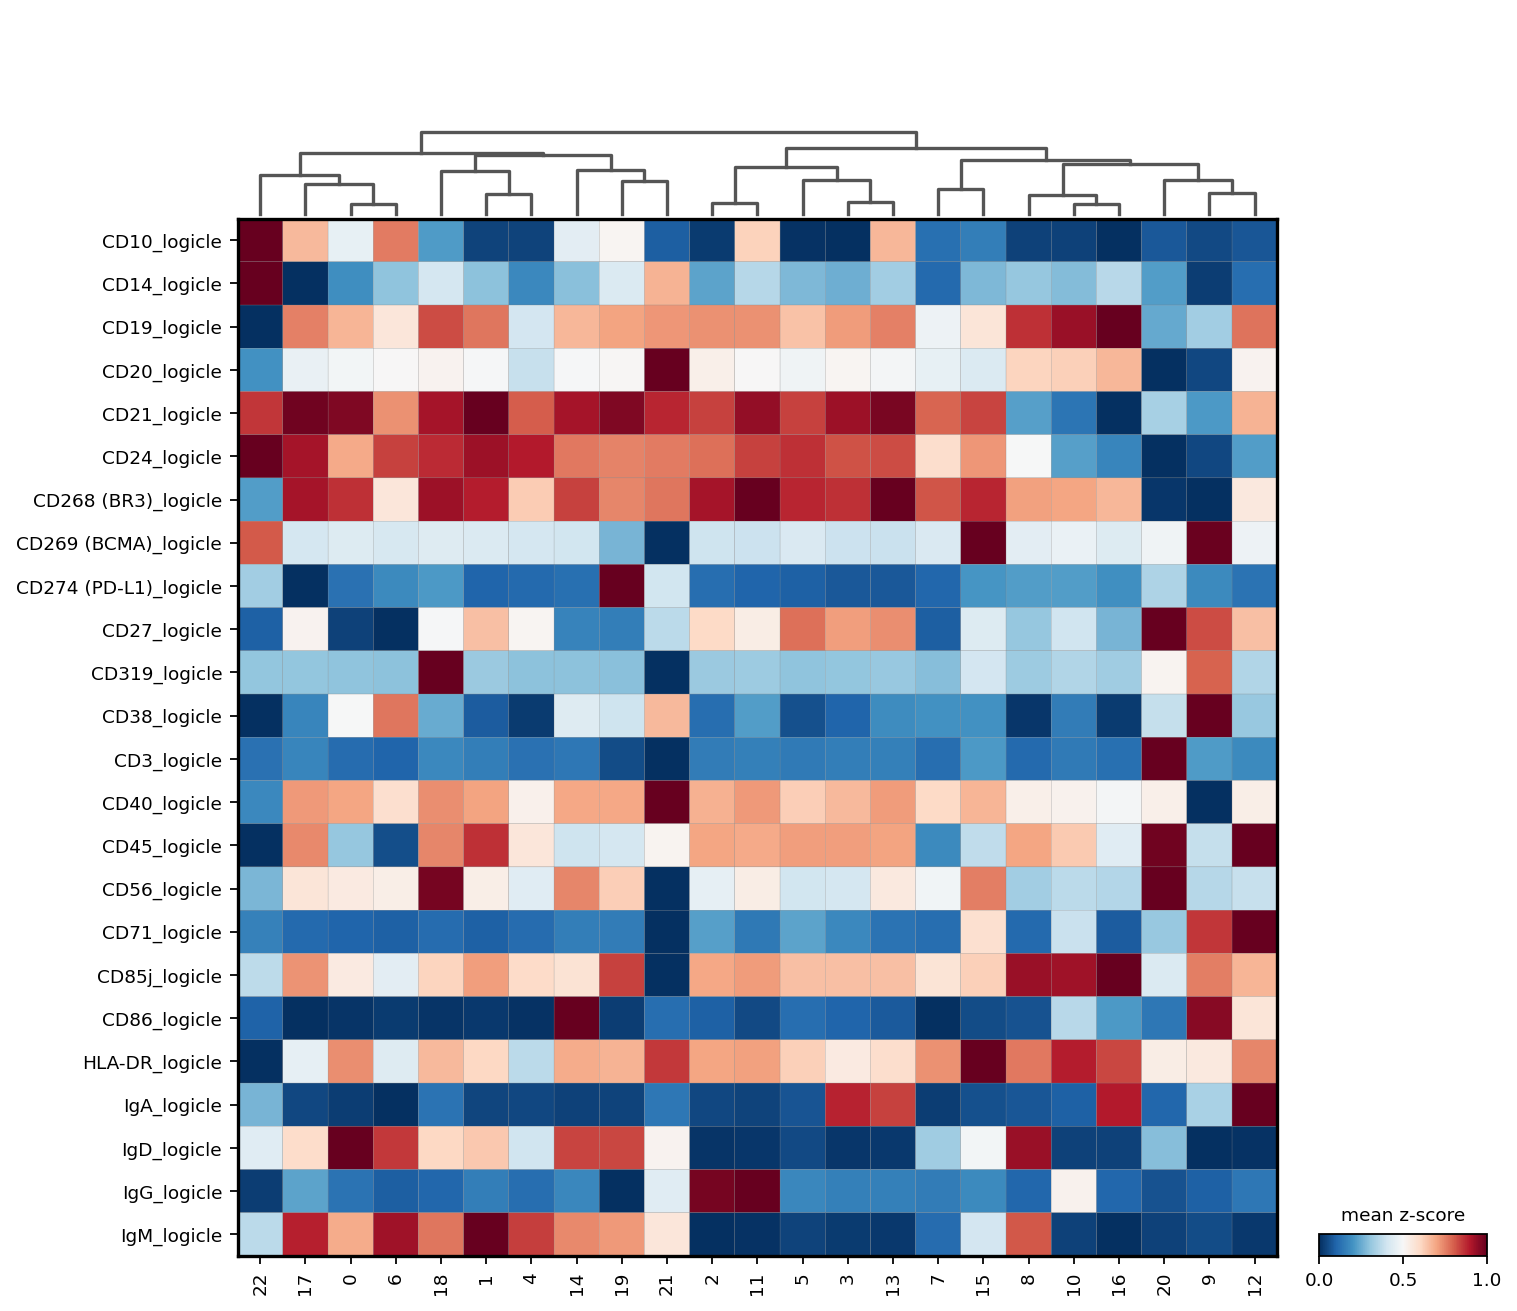

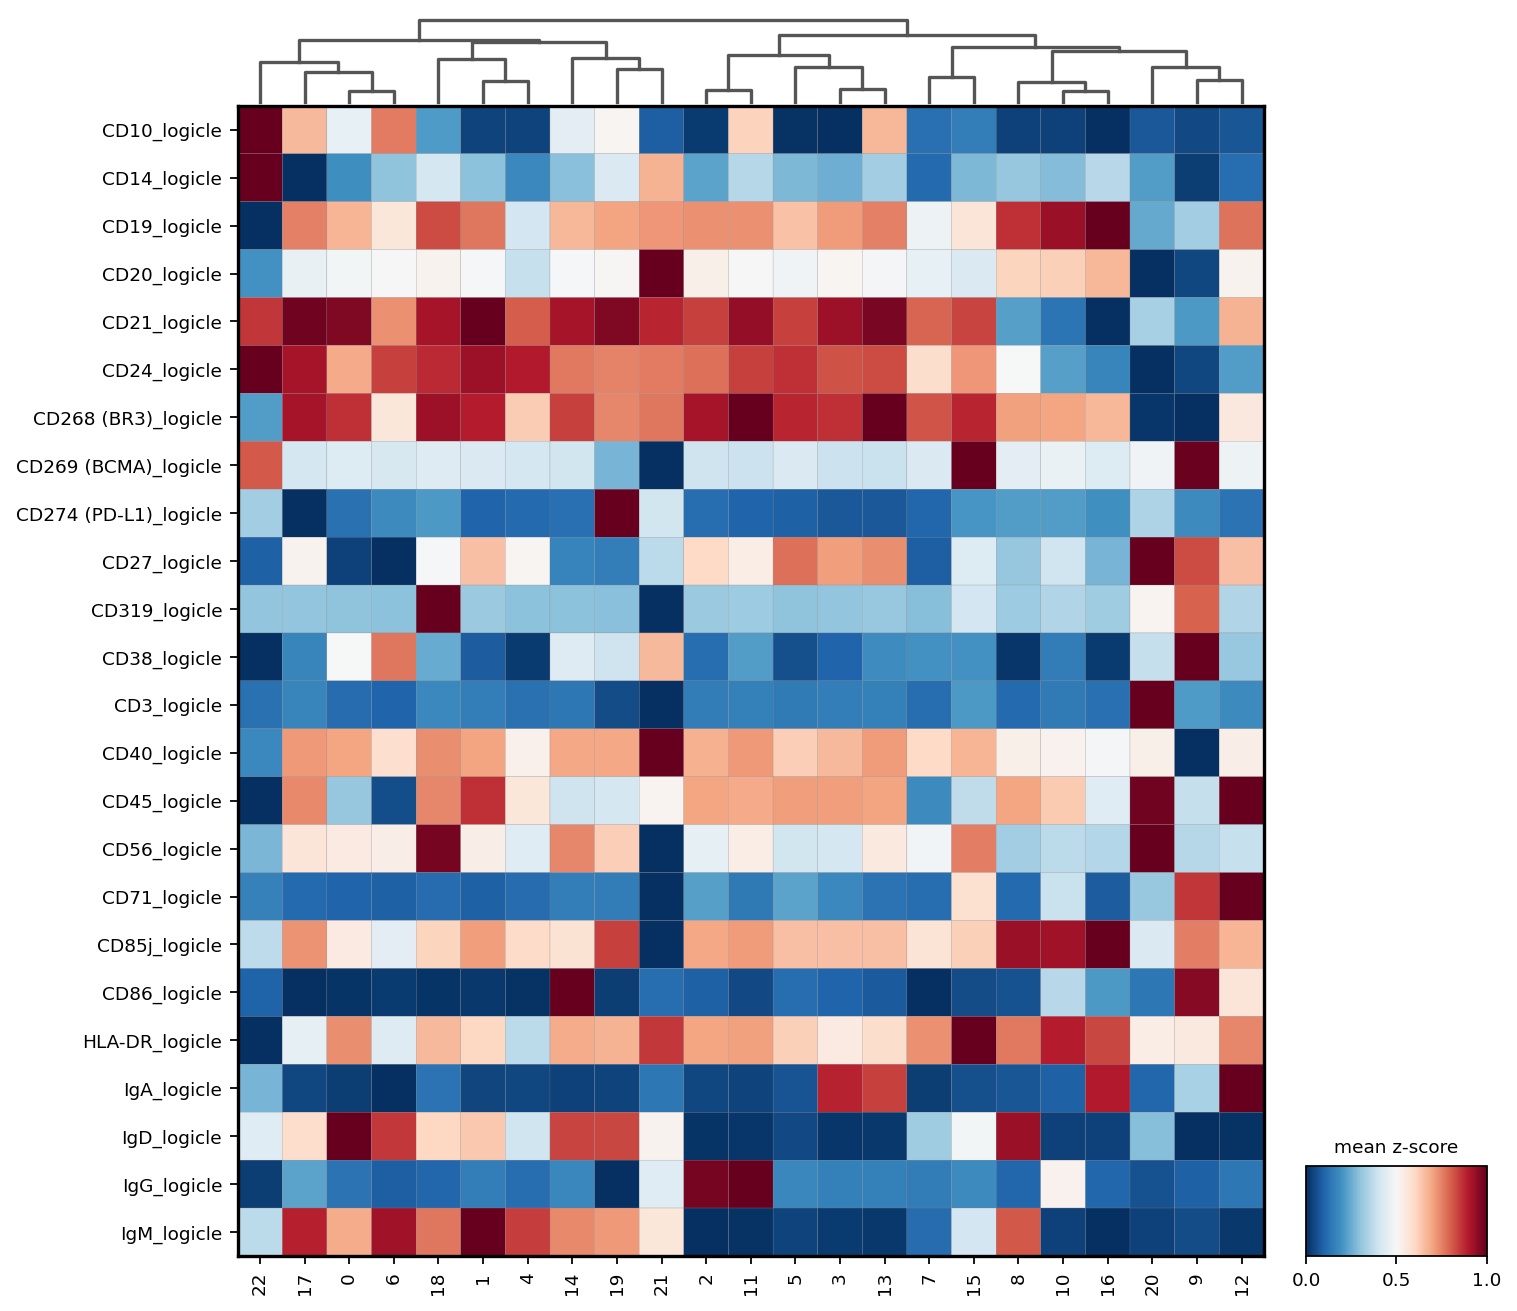

In [13]:
### add marker level rescaling to grouped mean heatmap

for label, sub_adata in adata_downsampled_celltypes.items():
    p1 = sc.pl.matrixplot(sub_adata, sub_adata.var_names.sort_values(), leiden_res[label],standard_scale='var', dendrogram=True,colorbar_title='mean z-score', cmap='RdBu_r', swap_axes=True, return_fig=True, show=True)

    p1.show()
    p1.savefig(fig_path  + label   + "_avg_mean_heatmap_marker_rescale_" + leiden_res[label] + "_" +panel + ".png",  dpi=400, bbox_inches='tight')


Key: total_b_cells_igPos_non_naive_b
Value: AnnData object with n_obs × n_vars = 1854019 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023', 'leiden_res_1.0'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds', 'dendrogram_leiden_res_1.0', 'leiden_res_1.0_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obse

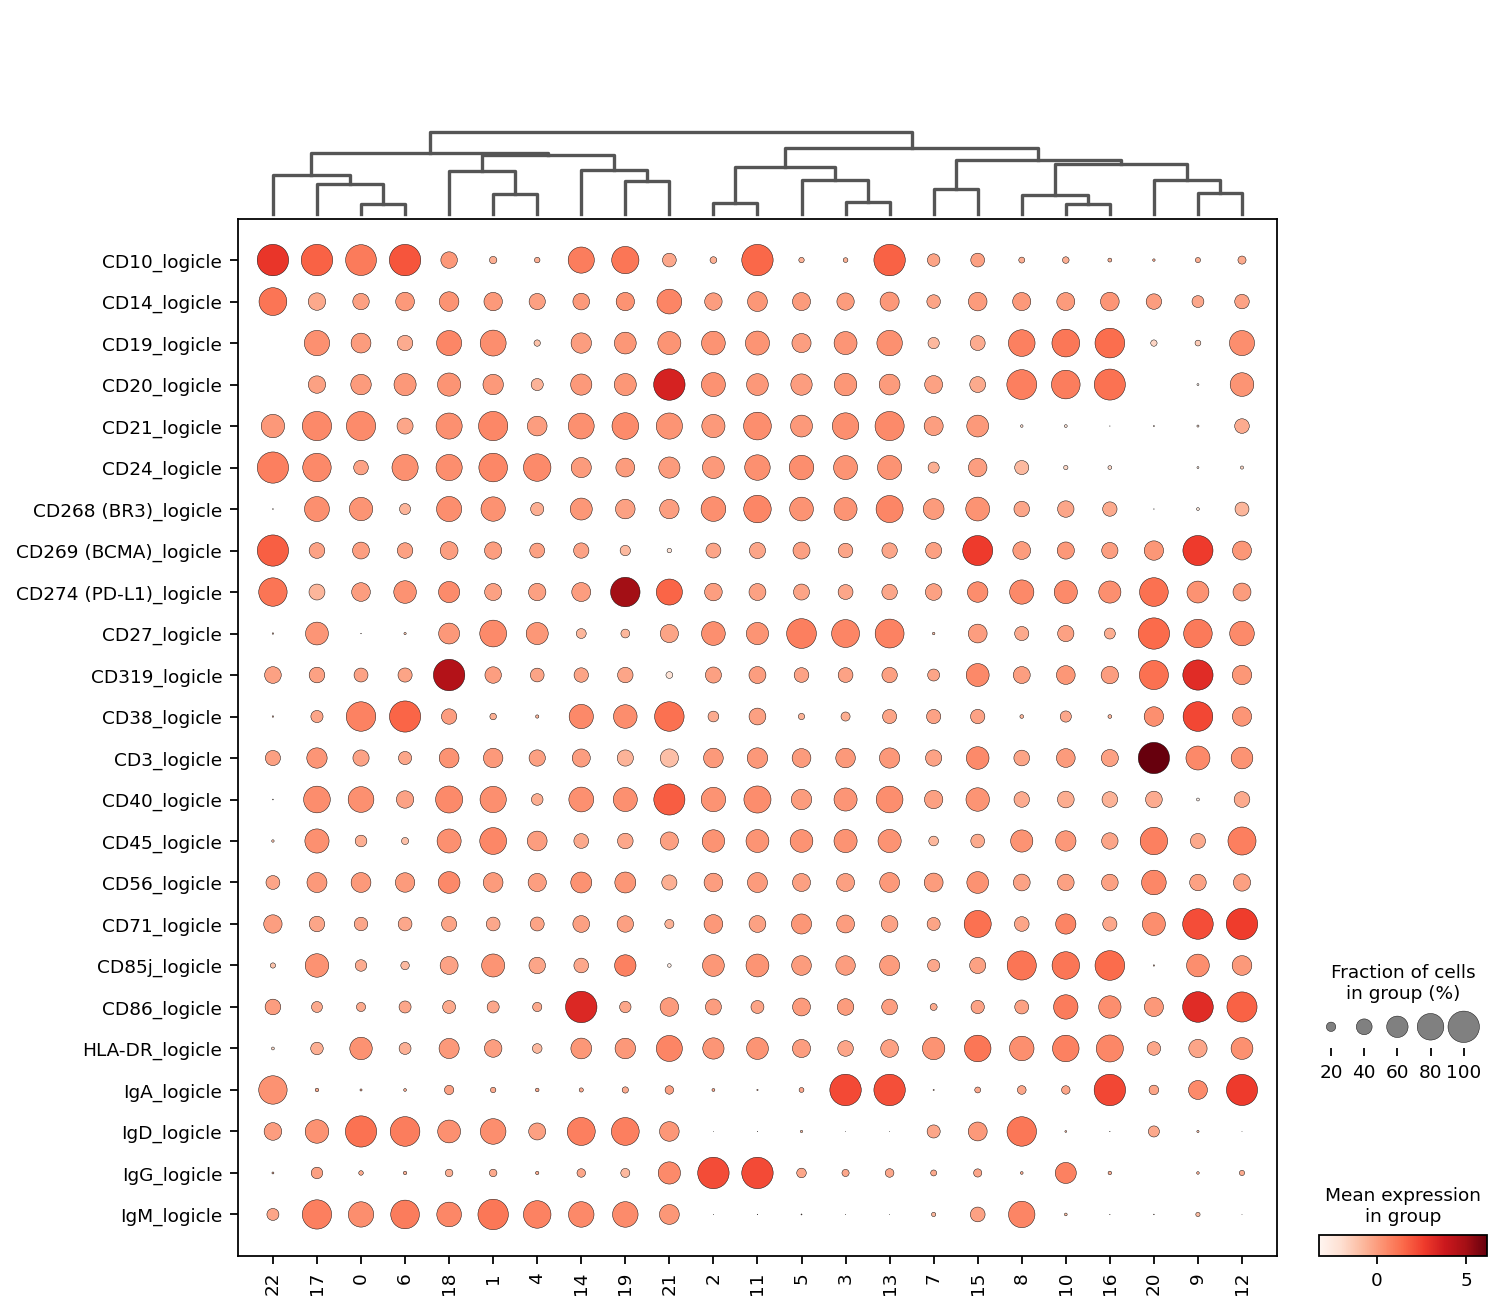

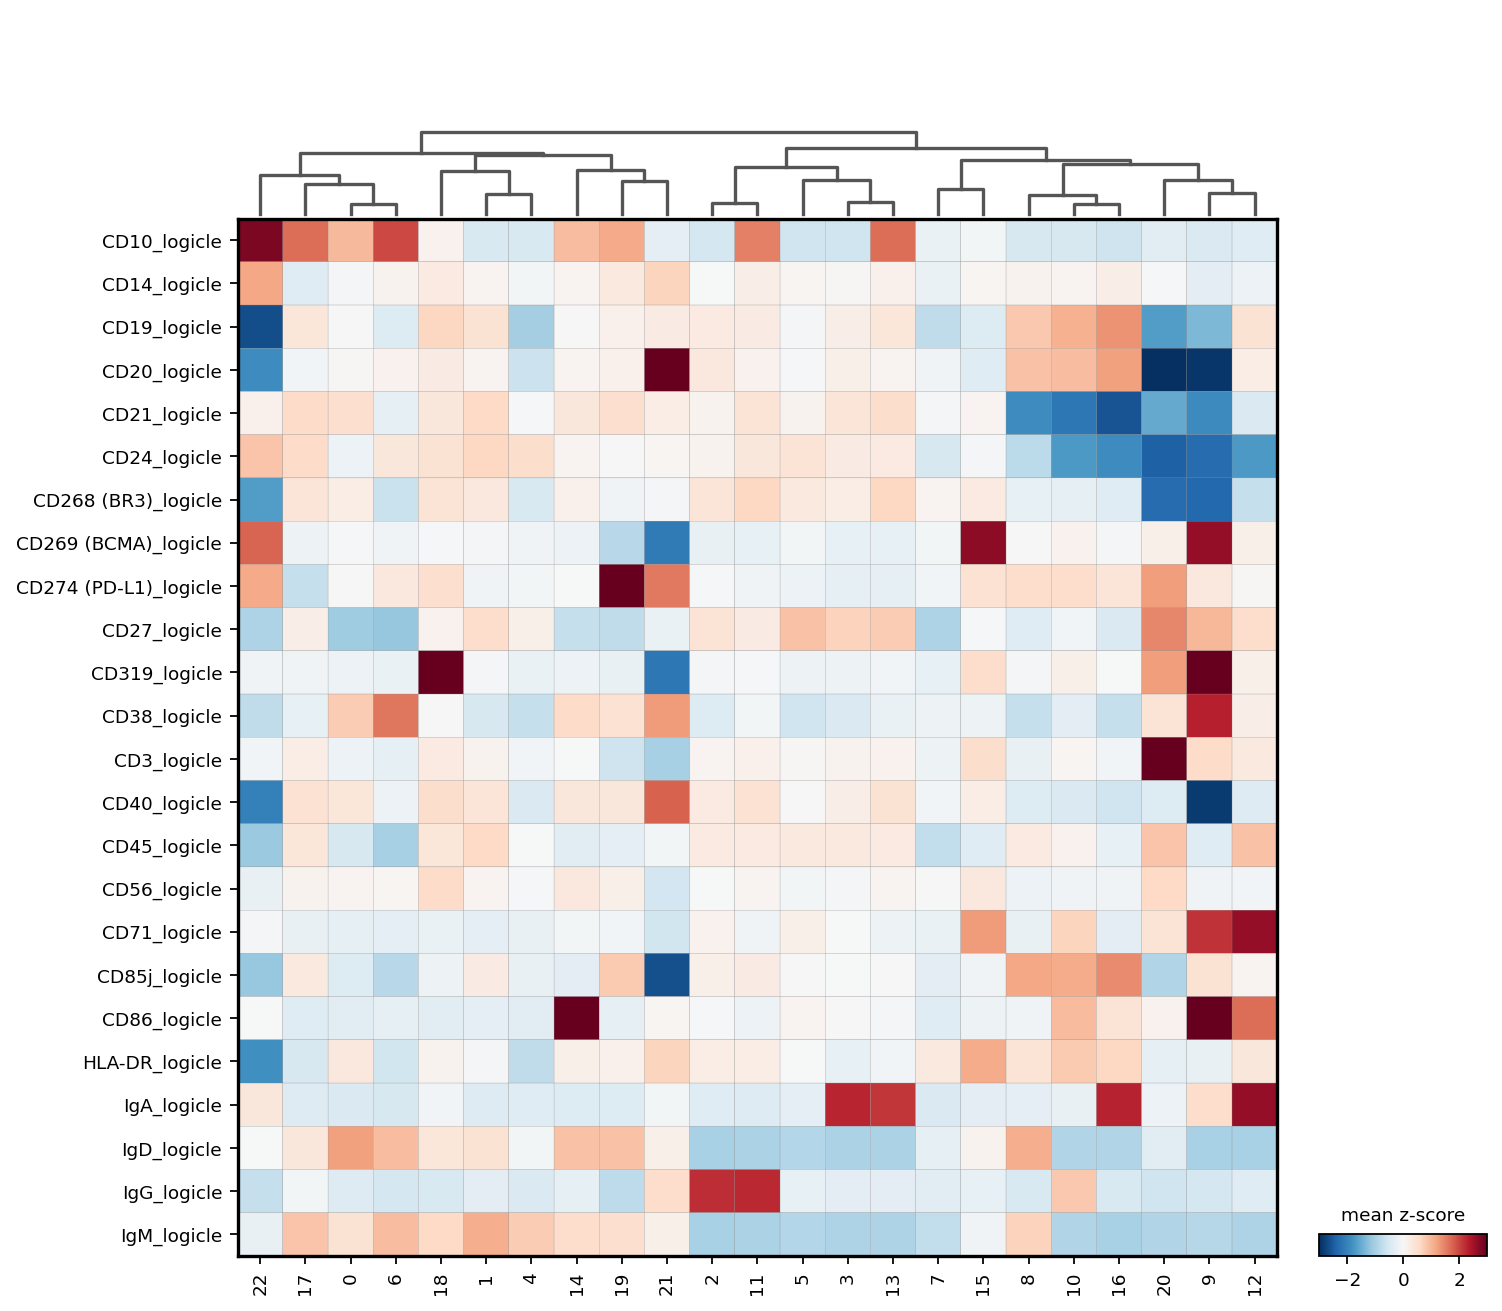

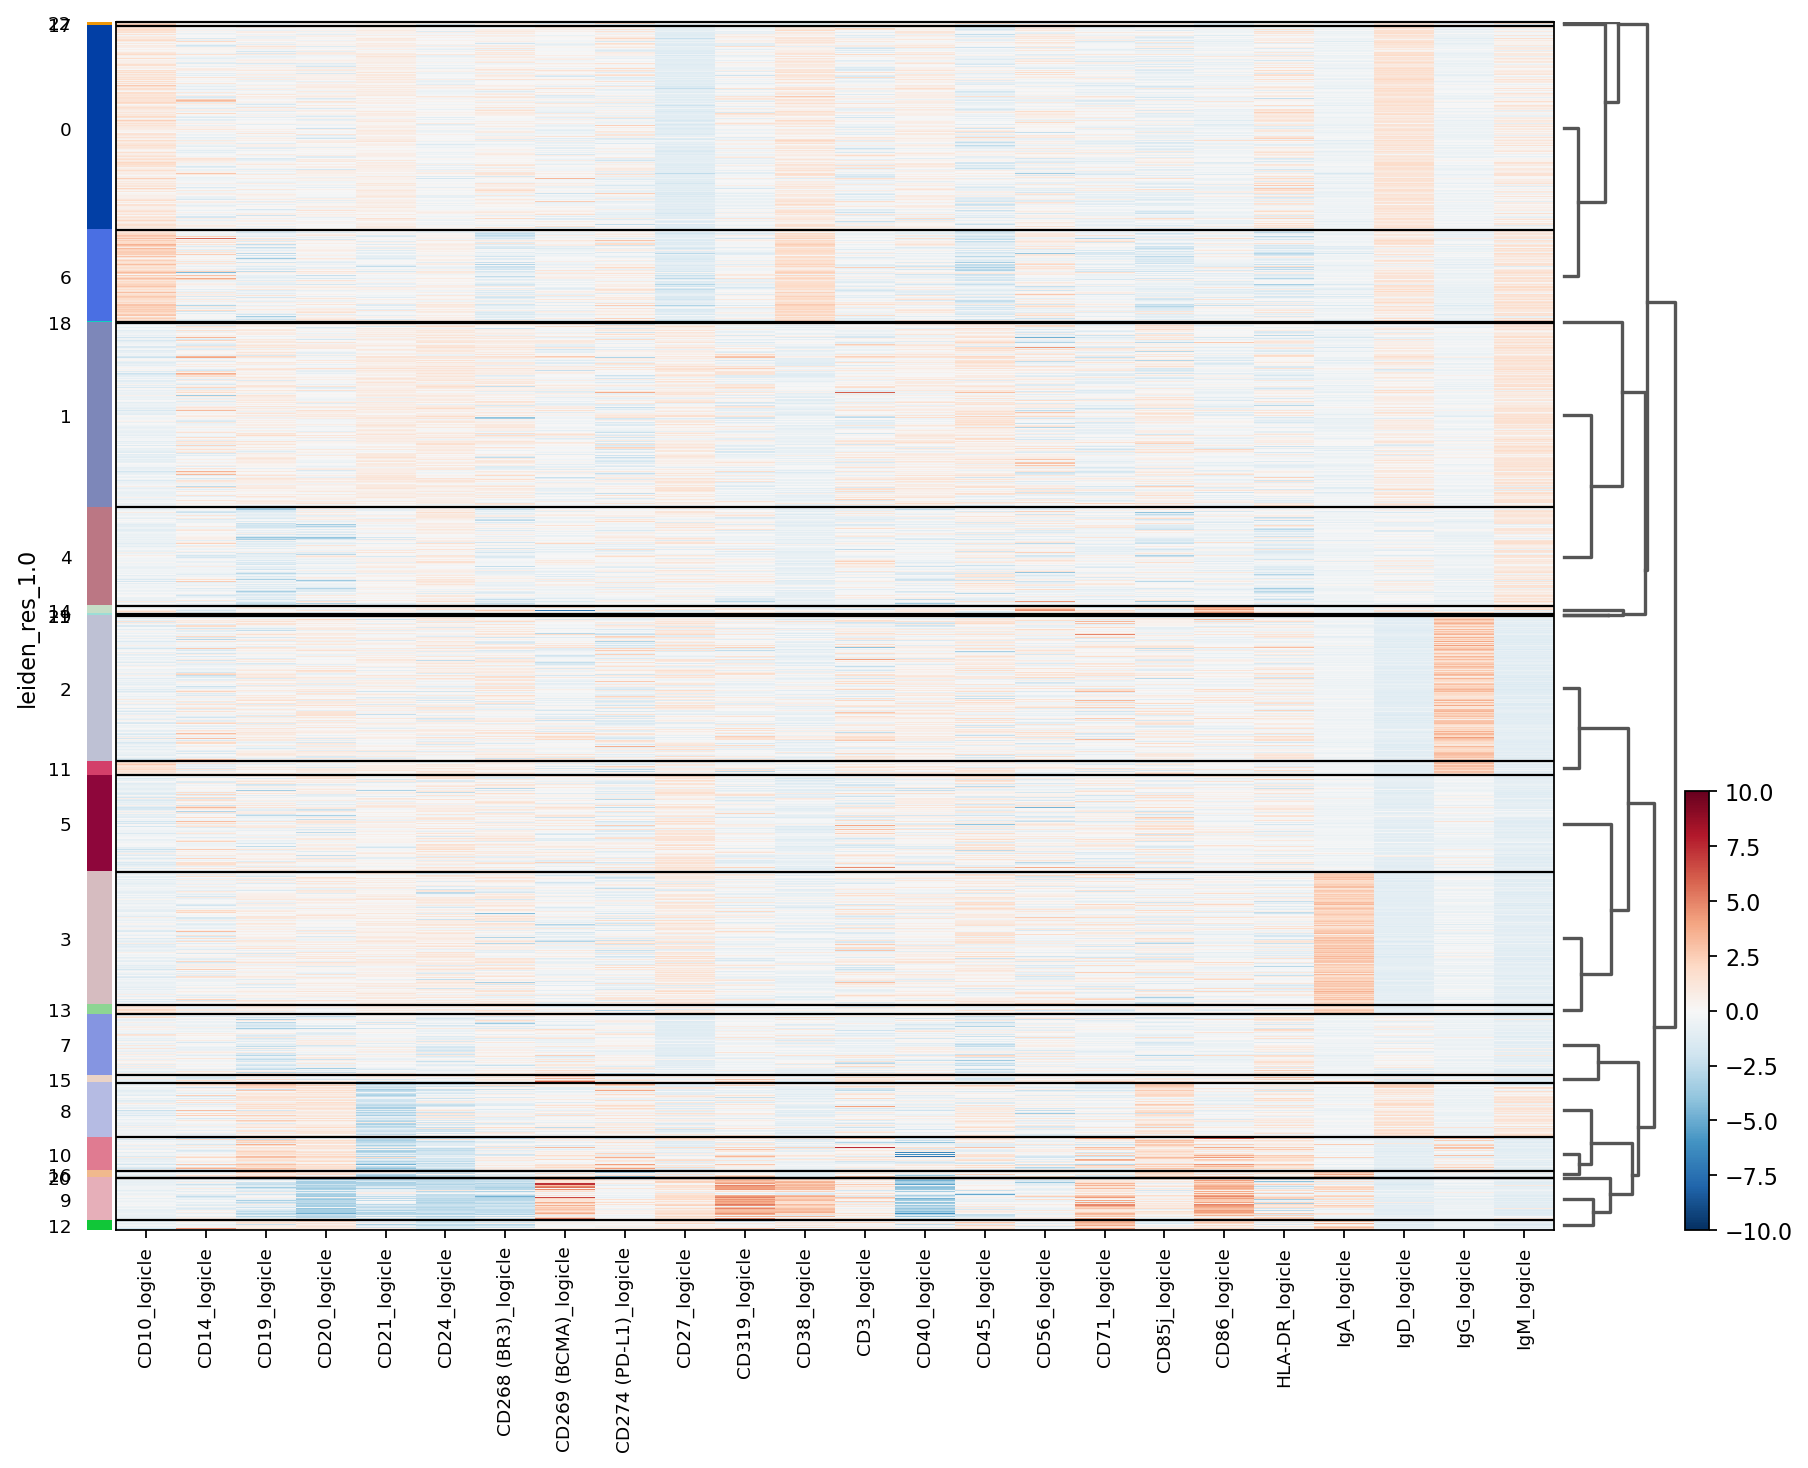

/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be chan

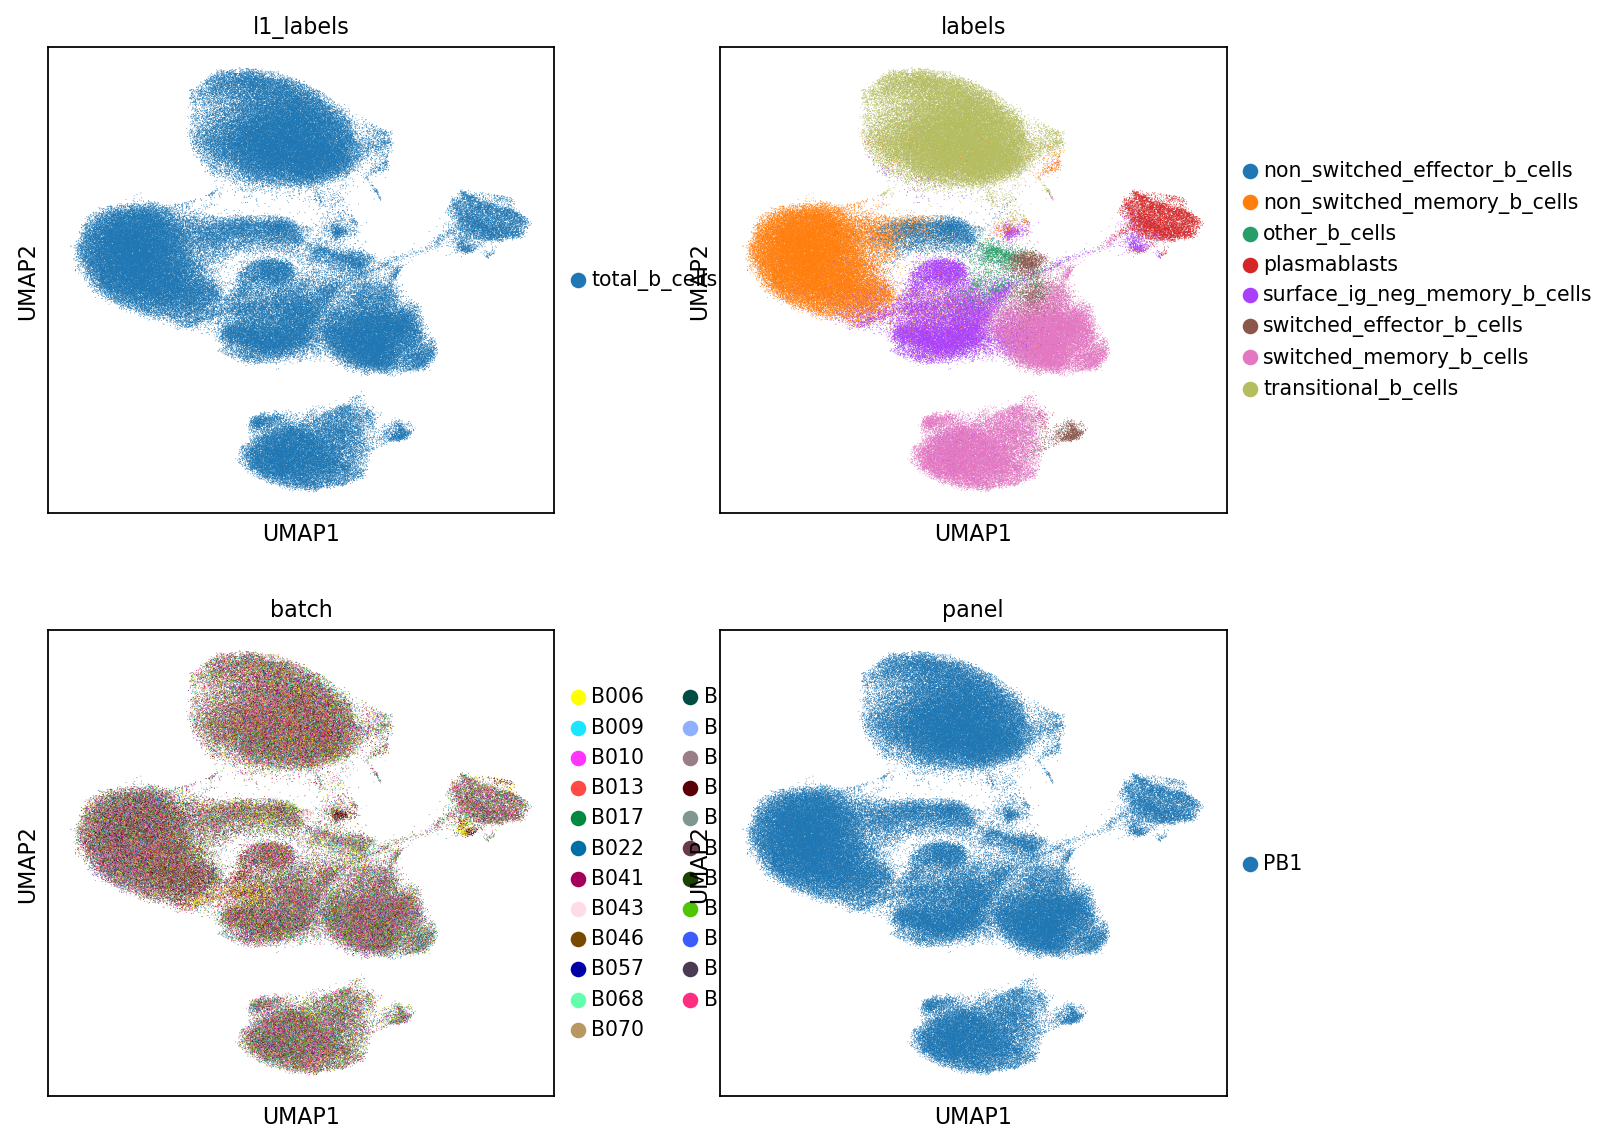

/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


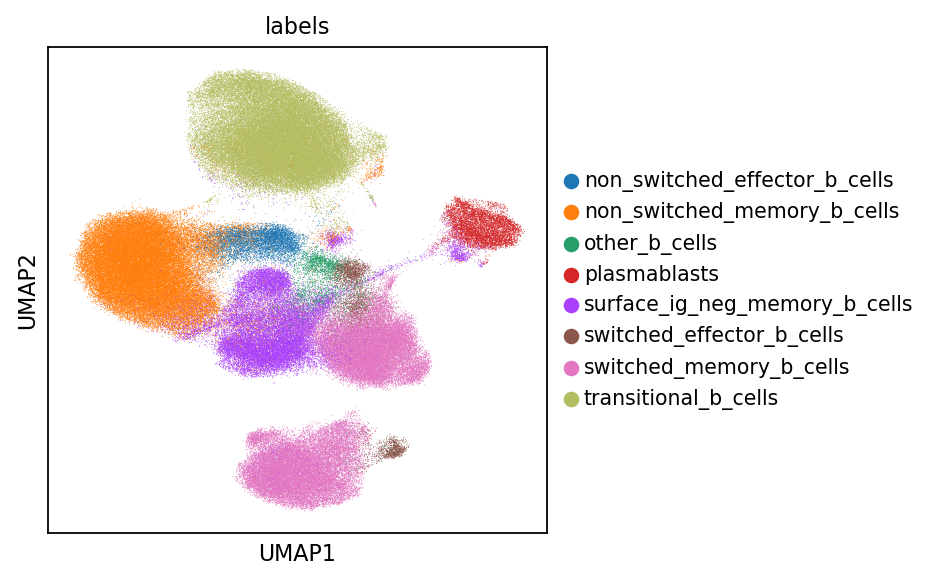

In [47]:
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    
    p1 = sc.pl.dotplot(sub_adata, sub_adata.var_names.sort_values(), leiden_res[label], dendrogram=True, swap_axes=True,return_fig=True, show=True)
    p1.savefig(fig_path  + label   + "_dotplot_exp_" + leiden_res[label] + "_" +panel + ".png",  dpi=400, bbox_inches='tight')

    p1 = sc.pl.matrixplot(sub_adata, sub_adata.var_names.sort_values(), leiden_res[label], dendrogram=True,colorbar_title='mean z-score', cmap='RdBu_r', swap_axes=True, vmin=-3, vmax=3, return_fig=True, show=True)
    p1.savefig(fig_path  + label   + "_avg_mean_heatmap_" + leiden_res[label] + "_" +panel + ".png",  dpi=400, bbox_inches='tight')

    sc.pl.heatmap(sub_adata, sub_adata.var_names.sort_values(), groupby=leiden_res[label], cmap='RdBu_r', dendrogram=True,show=True,figsize=(13,10), save= "_"+label   +"_cell_lvl_heatmap_" + leiden_res[label] + "_" +panel + ".png")

    p1=sy.plot.umap(sub_adata, color=['l1_labels','labels', 'batch','panel'], ncols =2, return_fig = True)
    p1.savefig(fig_path + label + "_umap_labels_batch_panel_"+ leiden_res[label] + "_" +panel + ".png",dpi=400, bbox_inches='tight')

    p1=sy.plot.umap(sub_adata, color=['labels'], return_fig = True)
    p1.savefig(fig_path + label + "_umap_l1_labels_"+ leiden_res[label] + "_" +panel + ".png",dpi=400, bbox_inches='tight')


    #p1 = sy.plot.umap(sub_adata, color= ['leiden_res_2', 'leiden_res_2.5', 'leiden_res_3', 'leiden_res_1.0'] ,return_fig = True, size = .5, ncols = 3)
    #p1.savefig(leiden_fig_path + label   + "_umap_leiden_resolutions_" + panel + ".png",  dpi=400, bbox_inches='tight')
    
    
    